# Bayesian online learning

This post explores the usefulness of conjugate priors in the context of online learning. Specifically we'll consider the following

1. Making predictions in real time via a bayesian model with conjugate upates.
2. Making predictions in real time via a bayesian model with conjugate updates when the underlying data "drifts."

Disclaimer: this post assumes some familiarity with bayesian inference. My previous post [A brief primer on conjugate priors]() covers enough details on conjugate priors to grasp this post. For a more in depth look at bayesian inference in general see this excellent [series of posts](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/) by Jake Vanderplas.

## Online learning

Online learning describes a machine learning context where a model is trained in real time as new data is observed.

[Click-through rates](https://en.wikipedia.org/wiki/Click-through_rate) provide a good example of how online learning works in practice. Consider a logistic regression model that predicts the probability a user $u$ will click a given ad $a$. An online training setting would have the following steps

1. A model predicts the probability that the user will click on the ad - $P(click\ \vert  \ u,a)$.
2. The ad $a$ is shown to the user $u$.
3. The outcome $y$ (a _click_ or _non-click_) is observed.
4. The training example $(u, a, y)$ is used to update the model parameters via stochastic gradient descent.

Note that the quick feedback loop (observing a click or non-click) and training algorithms such as SGD over mini-batches make online learning possible.

# Bayesian online learning

So what do we mean by "Bayesian online learning?" In this post we simply mean the following

1. Data is modeled according to a bayesian model with proper conjugate priors.
2. As new data is observed the posterior probability is updated using the closed form expression obtained by the choice of the conjugate prior.
3. At any point in this process we can obtain predictions from our model based on the most recent data observed.

For example consider the problem of trying to predict the maximum number of visits to a site per minute.

We begin with modeling the number of requests per minute $D$

$$
\begin{align}
&D\sim \text{Poi}(\lambda) \\
&\lambda\sim \Gamma(\alpha, \beta) \\
&\alpha,\beta\text{ constants}
\end{align}
$$

As explained in [my previous post]() the gamma distribution is the conjugate prior of the Poisson distribution. Modeled as such the posterior probability of our model is

$$
\begin{equation}
P(\lambda\ \vert \ D)\propto\Gamma(\alpha^{\prime},\beta^{\prime})
\end{equation}
$$

where

$$
\begin{align}
&\alpha^{\prime}=\sum_{i=1}^{n}{x_{i}+\alpha} \\
&\beta^{\prime}=n+\beta
\end{align}
$$

Now that we have a model for the number of site visits per minute we can extract a prediction of the maximum number of visits as follows. First we find $\lambda_{MAP}=\text{median}(\Gamma(\alpha^{\prime},\beta^{\prime}))$. Then we use the CDF of $\text{Poi}(\lambda_{MAP})$ to find the value $k$ (number of requests per minute) such that $P(X<k\ \vert \ \lambda_{MAP})<0.99$ (an arbitrarily chosen threshold).

# Simulation

Let's look at what we just described in code. We'll begin by simulating some data representing the number of site visits recorded over 1,000 one minute intervals.

In [1]:
import scipy.stats as ss
observations = ss.poisson(100).rvs(1000)

Next we define a simple model class that exposes two methods: one to update the paramters of the posterior probability and another to predict the maximum number of site visits.

In [2]:
class Model:
    def __init__(self, alpha, beta, confidence):
        self.alpha = alpha
        self.beta = beta
        self.confidence = confidence
        
    def predict(self):
        return ss.poisson.ppf(self.confidence, self.lambda_)
        
    def update(self, observation):
        self.alpha += observation
        self.beta += 1
        
    @property
    def lambda_(self):
        return ss.gamma.median(self.alpha, scale=1/self.beta)

We'll instantiate our model with "uninformative" priors.

In [3]:
model = Model(1e-3, 1e-3, 0.99)

Now we can simulate the online learning context. At each step we'll make a predict the max number of site visits we expect and then update the model

In [4]:
predictions = []
for observation in observations:
    predictions.append(model.predict())
    model.update(observation)

Now that we've simulated some data we can look at the results. In the plot below we'll draw a red line representing our model's prediction and then fill in a histogram representing the observed site visits as they were observed. The running number on the side represents the number of observations plotted.

Note that within only three observations the model has already honed in on its prediction.

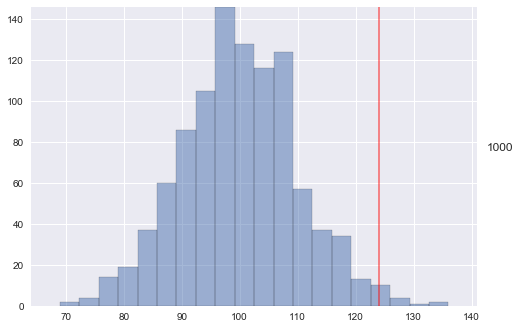

In [5]:
import utils
from IPython.display import HTML
ani = utils.visualize_learning(observations, predictions, bins=20)
HTML(ani.to_html5_video())

We can also calculate a simple evaluation of our model measuring how many observations were larger than our predicted max. Since we've simulated the data, it should line up with our confidence limit of 0.99.

In [6]:
sum(1 for o, p in zip(observations, predictions) if o <= p) / len(observations)

0.991

# Online training with drift

We will now consider one more example to demonstrate the ability of the model to "adapt" to changes in the distribution generating the observed data. The simulation will be similar to the one above, however every 100 steps we'll perturb the $\lambda$ parameter of the distribution generating the data. This resembles more closely what we might expect to see in real life. In the previous section we assumed that the expected number of visits per minute doesn't change. However if a real life scenario this could change over time. For example if the site provides news content it might experiences higher or lower volumes of traffic depending on what is happening in the world at a given moment.

In order to help the model respond to these changes we add an additional paramter to our `Model` class which specifies how many steps should be used to update the priors.

In [7]:
import collections
class Model:
    def __init__(self, alpha, beta, confidence, memory):
        self.alpha = alpha
        self.beta = beta
        self.confidence = confidence
        self.memory = collections.deque(maxlen=memory)
        
    def predict(self):
        return ss.poisson.ppf(self.confidence, self.lambda_)
        
    def update(self, observation):
        self.memory.append(observation)
        self.alpha = sum(self.memory)
        self.beta = len(self.memory)
        
    @property
    def lambda_(self):
        return ss.gamma.median(self.alpha, scale=1/self.beta)

In [8]:
model = Model(1e-3, 1e-3, 0.99, 50)

# create the distributions we'll sample from
# we save the distributions in a list for plotting later
lambda_ = 50
target_distributions = []
for _ in range(15):
    for _ in range(100):
        target_distributions.append(ss.poisson(lambda_))
    lambda_ += 3*ss.randint(low=-3, high=3).rvs()

In [9]:
# run the experiment, predicting and updating the model at each iteration
observations = []
predictions = []
model_parameters = []
for target_dist in target_distributions:
    prediction = model.predict()
    observation = target_dist.rvs()
    model.update(observation)
    observations.append(observation)
    predictions.append(prediction)
    model_parameters.append((
        ss.gamma(model.alpha, scale=1/model.beta),
        ss.poisson(model.lambda_)))

We'll plot our results in a similar fashion as above with a few additions:

- Only the 100 most recent observations are shown at a given time.
- The blue line is the "true" maximum estimate, $P(X<k|\lambda)$ where $\lambda$ is the parameter of the actual distribution generating the data at that step. Including this parameter helps us notice when the underlying distribution changes and observe that the model is learning as the red line "chases" the blue line.
- Posteriors of the model parameters are plotted on the right along with the generating distribution to see how the model is learning in real time.

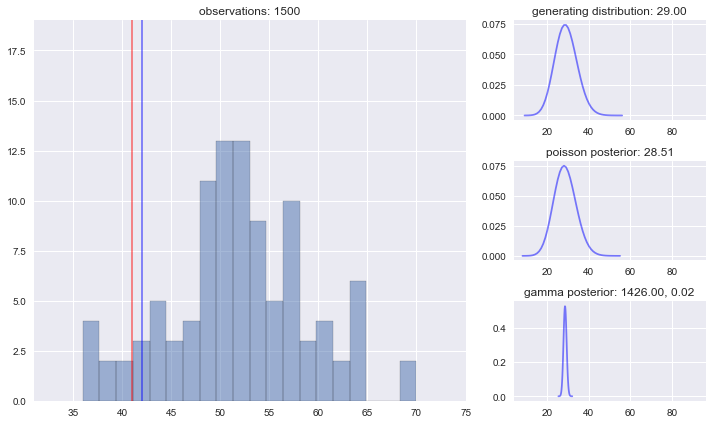

In [10]:
ani = utils.visualize_online_learning(
    observations,
    predictions,
    model_parameters,
    target_distributions,
    confidence=0.99,
    bins=20,
    last_n=100)
HTML(ani.to_html5_video())

# Conclusion

In this post we considered a toy problem with simulated data, however the usefulness of this method is well documented and has many applications. For further examples [this paper](http://proceedings.mlr.press/v23/agrawal12/agrawal12.pdf) is a good start.